# 07a_slope_to_edges (Guadalajara only)

This notebook __adds slope (grade_abs) to the edges__ by using a DEM raster.

## Import libraries

In [1]:
first_folder_path = '../../../'

In [2]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import osmnx as ox
import rasterio
from rasterio.plot import show

import os
import sys
module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [19]:
# ----- ----- ----- Projection to be used when needed ----- ----- -----
projected_crs = "EPSG:32613"

# ----- ----- ----- Save output locally?
local_save = False

## Load data

### __Load data__ - Nodes and edges

In [4]:
# Read file
nodes = gpd.read_file(first_folder_path + "data/processed/volvo/project_network_initial_guadalajara/guadalajara_nodes_proj_net_rebuilt.gpkg")
# Filter for data of interest
nodes = nodes[['osmid','x','y','street_count','geometry']]
# Turn to EPSG:4326
nodes = nodes.to_crs("EPSG:4326")
# Add x and y data
nodes['x'] = nodes['geometry'].x
nodes['y'] = nodes['geometry'].y

# Show
print(nodes.crs)
print(nodes.shape)
nodes.head(2)

EPSG:4326
(124621, 5)


,osmid,x,y,street_count,geometry
0,67637870229114485,-103.306309,20.711533,3,POINT (-103.30631 20.71153)
1,67640019229114922,-103.306102,20.711570,3,POINT (-103.30610 20.71157)


In [5]:
# Read file
edges = gpd.read_file(first_folder_path + "data/processed/volvo/project_network_initial_guadalajara/guadalajara_edges_proj_net_rebuilt.gpkg")
# Filter for data of interest
edges = edges[['u','v','key','geometry']]
# Add length data
if edges.crs != projected_crs:
    edges = edges.to_crs(projected_crs)
    print(f"Changed crs to {projected_crs}.")
edges['length'] = edges.length
# Turn to EPSG:4326
edges = edges.to_crs("EPSG:4326")

# Show
print(edges.crs)
print(edges.shape)
edges.head(2)

EPSG:4326
(197439, 5)


,u,v,key,geometry,length
0,67637870229114485,67640019229114922,0,"MULTILINESTRING ((-103.30631 20.71153, -103.30...",22.844750
1,67640019229114922,67640526229117504,0,"MULTILINESTRING ((-103.30610 20.71157, -103.30...",28.156418


### __Load data__ - Load and show DEM raster

Nodes crs: EPSG:4326.
Edges crs: EPSG:4326.
Raster crs: EPSG:4326.


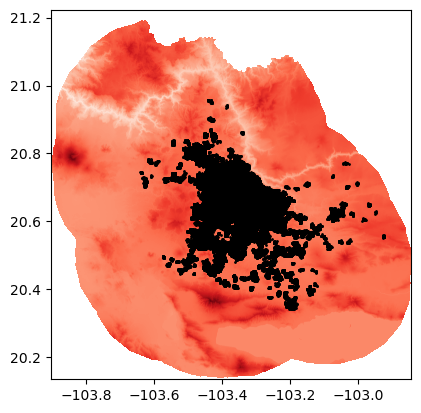

In [6]:
mde_path = first_folder_path + "data/processed/volvo/slope_to_edges_gdl/guadalajaramunsbuffer_r15m_4326.tif"

fig,ax = plt.subplots(1,1)

# Nodes
print(f"Nodes crs: {nodes.crs}.")
nodes.plot(ax=ax,zorder=1,color='black',markersize=1)
print(f"Edges crs: {nodes.crs}.")
edges.plot(ax=ax,zorder=0,color='lightgrey',linewidth=1)

with rasterio.open(mde_path) as mde:
    print(f"Raster crs: {mde.crs}.")
    show(mde,cmap='Reds',ax=ax)

## Create G from nodes and edges

In [7]:
# Prepare nodes and edges
if 'osmid' in nodes.columns:
    print(f"Nodes before dropping dups: {len(nodes)}.")
    nodes.drop_duplicates(subset='osmid',inplace=True)
    print(f"Nodes after dropping dups: {len(nodes)}.")
    nodes.set_index('osmid',inplace=True)

if 'u' in edges.columns:
    print(f"Edges before dropping dups: {len(edges)}.")
    edges.drop_duplicates(subset=['u','v','key'],inplace=True)
    print(f"Edges after dropping dups: {len(edges)}.")
    edges.set_index(['u','v','key'],inplace=True)

# Create graph
G = ox.convert.graph_from_gdfs(nodes, edges)
G

Nodes before dropping dups: 124621.
Nodes after dropping dups: 124621.
Edges before dropping dups: 197439.
Edges after dropping dups: 197439.


In [8]:
nodes.head(2)

,x,y,street_count,geometry
osmid,,,,
67637870229114485,-103.306309,20.711533,3,POINT (-103.30631 20.71153)
67640019229114922,-103.306102,20.711570,3,POINT (-103.30610 20.71157)


In [9]:
edges.head(2)

,,,geometry,length
u,v,key,,
67637870229114485,67640019229114922,0,"MULTILINESTRING ((-103.30631 20.71153, -103.30...",22.844750
67640019229114922,67640526229117504,0,"MULTILINESTRING ((-103.30610 20.71157, -103.30...",28.156418


## Add slope to nodes and edges

In [10]:
mde_path

'../../../data/processed/volvo/slope_to_edges_gdl/guadalajaramunsbuffer_r15m_4326.tif'

In [11]:
#elevations to nodes
G_elev_mde = ox.elevation.add_node_elevations_raster(G, mde_path,band=1)
assert not np.isnan(np.array(G_elev_mde.nodes(data="elevation"))[:, 1]).any()

In [12]:
nodes_df = ox.graph_to_gdfs(G_elev_mde, nodes=True, edges=False)

print(f"Nodes: {len(nodes_df)}.")
print(f"Nodes without elevation data: {nodes_df[['elevation']].isna().sum()[0]}.")

Nodes: 124621.
Nodes without elevation data: 0.


In [13]:
# Sloped length to edges
G_elev_mde = ox.distance.add_edge_lengths(G_elev_mde)
edges_df = ox.graph_to_gdfs(G_elev_mde, nodes=False, edges=True)
print(f"Edges without length data: {edges_df[['length']].isna().sum()[0]}.")

# Slope to edges
G_elev_mde = ox.elevation.add_edge_grades(G_elev_mde, add_absolute=True)
edges_df = ox.graph_to_gdfs(G_elev_mde, nodes=False, edges=True)
print(f"Edges without grade data: {edges_df[['grade']].isna().sum()[0]}.")
print(f"Edges without grade_abs data: {edges_df[['grade_abs']].isna().sum()[0]}.")

# G to nodes and edges
nodes_elev_mde, edges_elev_mde = ox.graph_to_gdfs(G_elev_mde, nodes=True, edges=True)

# LOG CODE - Print progress of script so far
mean_elev = round(nodes_elev_mde.elevation.mean(),2)
mean_slope = round(edges_elev_mde.grade_abs.mean(),2)
print(f"Assigned a mean elevation of {mean_elev} to nodes and mean slope of {mean_slope} to edges.")

Edges without length data: 0.
Edges without grade data: 336.
Edges without grade_abs data: 336.
Assigned a mean elevation of 1572.03 to nodes and mean slope of 0.03 to edges.


In [14]:
# Show
print(nodes_elev_mde.shape)
nodes_elev_mde.head(2)

(124621, 5)


,x,y,street_count,elevation,geometry
osmid,,,,,
67637870229114485,-103.306309,20.711533,3,1548.0,POINT (-103.30631 20.71153)
67640019229114922,-103.306102,20.711570,3,1548.0,POINT (-103.30610 20.71157)


In [15]:
# Show
print(edges_elev_mde.shape)
edges_elev_mde.head(2)

(197439, 4)


,,,geometry,length,grade,grade_abs
u,v,key,,,,
67637870229114485,67640019229114922,0,"MULTILINESTRING ((-103.30631 20.71153, -103.30...",21.897,0.0,0.0
67640019229114922,67640526229117504,0,"MULTILINESTRING ((-103.30610 20.71157, -103.30...",26.417,0.0,0.0


## Format output and save locally

In [16]:
# reset index
nodes_elev_mde.reset_index(inplace=True)
edges_elev_mde.reset_index(inplace=True)

#set street_count as float
nodes_elev_mde["street_count"] = nodes_elev_mde["street_count"].astype(float)

# Show
print(nodes_elev_mde.shape)
nodes_elev_mde.head(2)

(124621, 6)


,osmid,x,y,street_count,elevation,geometry
0,67637870229114485,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153)
1,67640019229114922,-103.306102,20.711570,3.0,1548.0,POINT (-103.30610 20.71157)


In [17]:
# Show
print(edges_elev_mde.shape)
edges_elev_mde.head(2)

(197439, 7)


,u,v,key,geometry,length,grade,grade_abs
0,67637870229114485,67640019229114922,0,"MULTILINESTRING ((-103.30631 20.71153, -103.30...",21.897,0.0,0.0
1,67640019229114922,67640526229117504,0,"MULTILINESTRING ((-103.30610 20.71157, -103.30...",26.417,0.0,0.0


In [18]:
if local_save:
    nodes_elev_mde.to_file(first_folder_path + "data/processed/volvo/slope_to_edges_gdl/nodes_elev_mde.gpkg", driver="GeoJSON")
    edges_elev_mde.to_file(first_folder_path + "data/processed/volvo/slope_to_edges_gdl/edges_elev_mde.gpkg", driver="GeoJSON")